In [2]:
import pandas as pd
import numpy as np
import torch
from nltk.tokenize import word_tokenize
from torch.utils.data import DataLoader
from torch import nn, optim
from string import punctuation
import json

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# 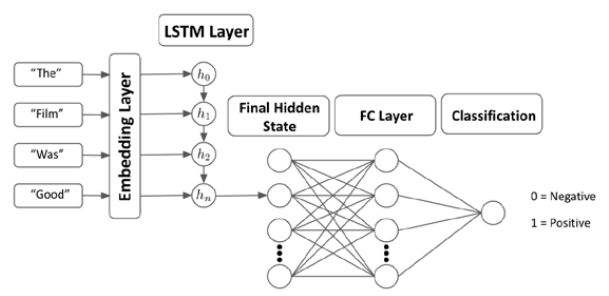

### Data Loading and Preprocessing

In [5]:
# Load and preprocess data
df = pd.read_csv('IMDB Dataset.csv')
df.shape,df.head(10)

((50000, 2),
                                               review sentiment
 0  One of the other reviewers has mentioned that ...  positive
 1  A wonderful little production. <br /><br />The...  positive
 2  I thought this was a wonderful way to spend ti...  positive
 3  Basically there's a family where a little boy ...  negative
 4  Petter Mattei's "Love in the Time of Money" is...  positive
 5  Probably my all-time favorite movie, a story o...  positive
 6  I sure would like to see a resurrection of a u...  positive
 7  This show was an amazing, fresh & innovative i...  negative
 8  Encouraged by the positive comments about this...  negative
 9  If you like original gut wrenching laughter yo...  positive)

### Tokenization and Vocabulary Creation

In [9]:
def tokenize_reviews(reviews):
    return [word_tokenize(review.translate(str.maketrans('', '', punctuation)).lower()) for review in reviews]

def create_vocab(tokenized_reviews):
    vocab = set(word for review in tokenized_reviews for word in review)
    word_to_int = {word: i+1 for i, word in enumerate(vocab)}
    return word_to_int, {i: word for word, i in word_to_int.items()}

reviews = df['review'].tolist()
tokenized_reviews = tokenize_reviews(reviews)
word_to_int_dict, int_to_word_dict = create_vocab(tokenized_reviews)




#def split_words_reviews(data):
#    
#    text = list(data['Review'].values)
#    clean_text = []
#    
#    for t in text:
#        clean_text.append(t.translate(str.maketrans('',
#                                    '',punctuation)).lower().rstrip())
#    
#    tokenized = [word_tokenize(x) for x in clean_text]
#    all_text = []
#    
#    for tokens in tokenized:
#        for t in tokens:
#            all_text.append(t)
#            
#    return tokenized,set(all_text)
#reviews,vocab = split_words_reviews(data)

#    <<=======================================================================>>

#def create_dictionaries(words):
#    
#    word_to_int_dict = {w:i+1 for i,w in enumerate(words)}
#    int_to_word_dict = {i:w for w,i in word_to_int_dict.items()}
#    
#    return word_to_int_dict, int_to_word_dict
#
#word_to_int_dict, int_to_word_dict = create_dictionaries(vocab)
#val = word_to_int_dict.get(4,None)
#val


### Prepare Data for PyTorch

In [15]:
from torch.utils.data import TensorDataset,DataLoader

#def pad_text(tokenized_text, seq_length):
#    
#    reviews = []
#    
#    for review in tokenized_text:
#        if len(review) >= seq_length:
#            reviews.append(review[:seq_length])
#        else:
#            reviews.append(['']*(seq_length-len(review))+review)
#    
#    return np.array(reviews)
#
#padded_sequence = pad_text(reviews,seq_length=50)
#padded_sequence[3]


def encode_reviews(reviews, word_to_int, seq_length=50):
    encoded = []
    for review in reviews:
        encoded_review = [word_to_int.get(word, 0) for word in review]
        if len(encoded_review) < seq_length:
            encoded_review = [0] * (seq_length - len(encoded_review)) + encoded_review
        else:
            encoded_review = encoded_review[:seq_length]
        encoded.append(encoded_review)
    return encoded


encoded_reviews = encode_reviews(tokenized_reviews, word_to_int_dict)
labels = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values

# Convert to Tensor
features = torch.tensor(encoded_reviews, dtype=torch.long)
labels = torch.tensor(labels, dtype=torch.float32)

# Create TensorDataset and DataLoader
dataset = TensorDataset(features, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

batch_size = 50
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size)


### Model Definition

In [18]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, output_size=1, embedding_dim=400, hidden_dim=256, n_layers=2, drop_prob=0.5):
        super(SentimentRNN, self).__init__()
        self.hidden_dim = hidden_dim  # Add this line to initialize hidden_dim
        self.n_layers = n_layers  # Add this line to initialize n_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        return self.sigmoid(out).view(x.size(0), -1)[:, -1], hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        return (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

# Instantiate the model
vocab_size = len(word_to_int_dict) + 1  # plus one for padding
net = SentimentRNN(vocab_size)


In [19]:
def train_model(net, train_loader, val_loader, epochs=4, lr=0.001, print_every=100):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    clip = 5

    for e in range(epochs):
        net.train()
        h = net.init_hidden(batch_size)
        
        for counter, (inputs, labels) in enumerate(tqdm(train_loader), 1):
            inputs, labels = inputs.to(torch.int64), labels.to(torch.float32)  # Ensure correct data types
            h = tuple([each.data for each in h])
            net.zero_grad()
            output, h = net(inputs, h)
            loss = criterion(output, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            optimizer.step()

            if counter % print_every == 0:
                val_h = net.init_hidden(batch_size)
                val_losses = []
                net.eval()
                with torch.no_grad():
                    for inputs, labels in val_loader:
                        inputs, labels = inputs.to(torch.int64), labels.to(torch.float32)  # Ensure correct data types
                        val_h = tuple([each.data for each in val_h])
                        output, val_h = net(inputs, val_h)
                        val_loss = criterion(output, labels)
                        val_losses.append(val_loss.item())
                        
                net.train()
                print(f"Epoch: {e+1}/{epochs}, Step: {counter}, Loss: {loss.item():.4f}, Val Loss: {np.mean(val_losses):.4f}")

# Instantiate the model and DataLoader objects
vocab_size = len(word_to_int_dict) + 1  # plus one for padding
net = SentimentRNN(vocab_size)

# Training the model
train_model(net, train_loader, val_loader)


 12%|██████████                                                                      | 100/800 [00:50<19:11,  1.65s/it]

Epoch: 1/4, Step: 100, Loss: 0.6438, Val Loss: 0.6698


 25%|████████████████████                                                            | 200/800 [01:38<16:24,  1.64s/it]

Epoch: 1/4, Step: 200, Loss: 0.6526, Val Loss: 0.7016


 38%|██████████████████████████████                                                  | 300/800 [02:27<13:56,  1.67s/it]

Epoch: 1/4, Step: 300, Loss: 0.6275, Val Loss: 0.6346


 50%|████████████████████████████████████████                                        | 400/800 [03:15<10:57,  1.64s/it]

Epoch: 1/4, Step: 400, Loss: 0.7727, Val Loss: 0.6394


 62%|██████████████████████████████████████████████████                              | 500/800 [04:02<08:18,  1.66s/it]

Epoch: 1/4, Step: 500, Loss: 0.6458, Val Loss: 0.5933


 75%|████████████████████████████████████████████████████████████                    | 600/800 [04:49<05:32,  1.66s/it]

Epoch: 1/4, Step: 600, Loss: 0.4749, Val Loss: 0.5786


 88%|██████████████████████████████████████████████████████████████████████          | 700/800 [05:38<02:46,  1.66s/it]

Epoch: 1/4, Step: 700, Loss: 0.4715, Val Loss: 0.5569


100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [06:28<00:00,  2.06it/s]


Epoch: 1/4, Step: 800, Loss: 0.6679, Val Loss: 0.5751


 12%|██████████                                                                      | 100/800 [00:48<18:56,  1.62s/it]

Epoch: 2/4, Step: 100, Loss: 0.3643, Val Loss: 0.5809


 25%|████████████████████                                                            | 200/800 [01:38<16:39,  1.67s/it]

Epoch: 2/4, Step: 200, Loss: 0.4872, Val Loss: 0.5394


 38%|██████████████████████████████                                                  | 300/800 [02:27<13:53,  1.67s/it]

Epoch: 2/4, Step: 300, Loss: 0.3536, Val Loss: 0.5503


 50%|████████████████████████████████████████                                        | 400/800 [03:17<10:55,  1.64s/it]

Epoch: 2/4, Step: 400, Loss: 0.5156, Val Loss: 0.5210


 62%|██████████████████████████████████████████████████                              | 500/800 [04:07<08:15,  1.65s/it]

Epoch: 2/4, Step: 500, Loss: 0.4684, Val Loss: 0.5249


 75%|████████████████████████████████████████████████████████████                    | 600/800 [04:57<05:36,  1.68s/it]

Epoch: 2/4, Step: 600, Loss: 0.4668, Val Loss: 0.5115


 88%|██████████████████████████████████████████████████████████████████████          | 700/800 [05:48<02:47,  1.68s/it]

Epoch: 2/4, Step: 700, Loss: 0.5199, Val Loss: 0.5162


100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [06:39<00:00,  2.00it/s]


Epoch: 2/4, Step: 800, Loss: 0.4746, Val Loss: 0.5433


 12%|██████████                                                                      | 100/800 [00:48<19:32,  1.67s/it]

Epoch: 3/4, Step: 100, Loss: 0.4512, Val Loss: 0.5224


 25%|████████████████████                                                            | 200/800 [01:37<16:18,  1.63s/it]

Epoch: 3/4, Step: 200, Loss: 0.3505, Val Loss: 0.5400


 38%|██████████████████████████████                                                  | 300/800 [02:25<13:44,  1.65s/it]

Epoch: 3/4, Step: 300, Loss: 0.4848, Val Loss: 0.5160


 50%|████████████████████████████████████████                                        | 400/800 [03:14<10:56,  1.64s/it]

Epoch: 3/4, Step: 400, Loss: 0.3528, Val Loss: 0.5127


 62%|██████████████████████████████████████████████████                              | 500/800 [04:01<08:06,  1.62s/it]

Epoch: 3/4, Step: 500, Loss: 0.3988, Val Loss: 0.5469


 75%|████████████████████████████████████████████████████████████                    | 600/800 [04:49<05:34,  1.67s/it]

Epoch: 3/4, Step: 600, Loss: 0.3424, Val Loss: 0.5169


 88%|██████████████████████████████████████████████████████████████████████          | 700/800 [05:38<02:52,  1.72s/it]

Epoch: 3/4, Step: 700, Loss: 0.4132, Val Loss: 0.5181


100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [06:28<00:00,  2.06it/s]


Epoch: 3/4, Step: 800, Loss: 0.3919, Val Loss: 0.5666


 12%|██████████                                                                      | 100/800 [00:47<19:10,  1.64s/it]

Epoch: 4/4, Step: 100, Loss: 0.4154, Val Loss: 0.5749


 25%|████████████████████                                                            | 200/800 [01:35<16:18,  1.63s/it]

Epoch: 4/4, Step: 200, Loss: 0.2787, Val Loss: 0.5651


 38%|██████████████████████████████                                                  | 300/800 [02:24<13:42,  1.65s/it]

Epoch: 4/4, Step: 300, Loss: 0.4207, Val Loss: 0.5525


 50%|████████████████████████████████████████                                        | 400/800 [03:13<11:22,  1.71s/it]

Epoch: 4/4, Step: 400, Loss: 0.2801, Val Loss: 0.5911


 62%|██████████████████████████████████████████████████                              | 500/800 [04:03<08:24,  1.68s/it]

Epoch: 4/4, Step: 500, Loss: 0.3401, Val Loss: 0.5591


 75%|████████████████████████████████████████████████████████████                    | 600/800 [04:51<05:25,  1.63s/it]

Epoch: 4/4, Step: 600, Loss: 0.2306, Val Loss: 0.5448


 88%|██████████████████████████████████████████████████████████████████████          | 700/800 [05:38<02:42,  1.62s/it]

Epoch: 4/4, Step: 700, Loss: 0.3541, Val Loss: 0.5634


100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [06:27<00:00,  2.07it/s]

Epoch: 4/4, Step: 800, Loss: 0.1499, Val Loss: 0.6142


In [22]:
def evaluate_model(net, test_loader):
    net.eval()
    test_losses = []
    num_correct = 0
    criterion = nn.BCELoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            h = net.init_hidden(inputs.size(0))  # Initialize hidden state with the batch size
            output, h = net(inputs, h)
            loss = criterion(output, labels)
            test_losses.append(loss.item())
            preds = torch.round(output.squeeze())
            num_correct += torch.sum(preds == labels).item()

    print(f"Test Loss: {np.mean(test_losses):.4f}")
    print(f"Test Accuracy: {num_correct / len(test_loader.dataset):.2f}")

# Evaluating the model
evaluate_model(net, val_loader)



Test Loss: 0.5943
Test Accuracy: 0.77


In [25]:
def preprocess_review(review, seq_length=50):
    review = review.translate(str.maketrans('', '', punctuation)).lower()
    tokenized = word_tokenize(review)
    if len(tokenized) < seq_length:
        tokenized = ['0'] * (seq_length - len(tokenized)) + tokenized
    else:
        tokenized = tokenized[:seq_length]
    return [word_to_int_dict.get(word, 0) for word in tokenized]

def predict_review(net, review):
    net.eval()
    review_ints = torch.tensor([preprocess_review(review)], dtype=torch.long)
    h = net.init_hidden(1)  # Initialize hidden state with batch size of 1
    with torch.no_grad():
        output, h = net(review_ints, h)
        prediction = "Positive" if output.item() >= 0.5 else "Negative"
    print(f"Review: {review}")
    print(f"Prediction: {prediction} (Output: {output.item():.4f})")

# Example Prediction
predict_review(net, "The film was bad")


Review: This is  a fantastic movie
Prediction: Negative (Output: 0.0042)


# Implementing Bert Tokenizer

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode the reviews
def tokenize_reviews_bert(reviews, tokenizer, max_length=50):
    input_ids = []
    attention_masks = []
    
    for review in reviews:
        encoded_dict = tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    return input_ids, attention_masks

# Apply the tokenizer to the reviews
reviews = data['review'].tolist()
input_ids, attention_masks = tokenize_reviews_bert(reviews, tokenizer)

# Convert labels to tensor
labels = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values
labels = torch.tensor(labels, dtype=torch.float32)

# Create TensorDataset and DataLoader
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

batch_size = 50
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size)


### Model Definition with BERT Embeddings

from transformers import BertModel

class SentimentRNN(nn.Module):
    def __init__(self, hidden_dim=256, output_size=1, n_layers=2, drop_prob=0.5):
        super(SentimentRNN, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(self.bert.config.hidden_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask, hidden):
        bert_outputs = self.bert(input_ids, attention_mask=attention_mask)
        lstm_out, hidden = self.lstm(bert_outputs.last_hidden_state, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        return self.sigmoid(out).view(input_ids.size(0), -1)[:, -1], hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        return (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

# Instantiate the model
net = SentimentRNN()


### Training Loop with BERT Tokenizer Outputs

def train_model(net, train_loader, val_loader, epochs=4, lr=0.001, print_every=100):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    clip = 5

    for e in range(epochs):
        net.train()
        h = net.init_hidden(batch_size)
        
        for counter, (input_ids, attention_masks, labels) in enumerate(tqdm(train_loader), 1):
            input_ids, attention_masks, labels = input_ids.to(torch.int64), attention_masks.to(torch.int64), labels.to(torch.float32)
            h = tuple([each.data for each in h])
            net.zero_grad()
            output, h = net(input_ids, attention_masks, h)
            loss = criterion(output, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            optimizer.step()

            if counter % print_every == 0:
                val_h = net.init_hidden(batch_size)
                val_losses = []
                net.eval()
                with torch.no_grad():
                    for input_ids, attention_masks, labels in val_loader:
                        input_ids, attention_masks, labels = input_ids.to(torch.int64), attention_masks.to(torch.int64), labels.to(torch.float32)
                        val_h = tuple([each.data for each in val_h])
                        output, val_h = net(input_ids, attention_masks, val_h)
                        val_loss = criterion(output, labels)
                        val_losses.append(val_loss.item())
                        
                net.train()
                print(f"Epoch: {e+1}/{epochs}, Step: {counter}, Loss: {loss.item():.4f}, Val Loss: {np.mean(val_losses):.4f}")

# Training the model
train_model(net, train_loader, val_loader)


### Evaluation and Prediction

def evaluate_model(net, test_loader):
    net.eval()
    test_losses = []
    num_correct = 0
    criterion = nn.BCELoss()

    with torch.no_grad():
        for input_ids, attention_masks, labels in test_loader:
            output, _ = net(input_ids, attention_masks, None)
            loss = criterion(output, labels)
            test_losses.append(loss.item())
            preds = torch.round(output.squeeze())
            num_correct += torch.sum(preds == labels).item()

    print(f"Test Loss: {np.mean(test_losses):.4f}")
    print(f"Test Accuracy: {num_correct / len(test_loader.dataset):.2f}")

# Evaluating the model
evaluate_model(net, val_loader)

def predict_review(net, review):
    net.eval()
    input_ids, attention_mask = tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=50,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    ).values()
    with torch.no_grad():
        output, _ = net(input_ids, attention_mask, None)
        prediction = "Positive" if output.item() >= 0.5 else "Negative"
    print(f"Review: {review}")
    print(f"Prediction: {prediction} (Output: {output.item():.4f})")

# Example Prediction
predict_review(net, "The film was bad")
